LDA で分野混合の用語クラスタリングを実行する (第二部)
開発: 黒田 航 (kow.kuroda@gmail.com)

2024/03/01 に料理用語の処理を追加
2024/03/02 にskippy4gram の処理と追加 (階層クラスタリングの扱いは不十分)
2024/03/19 にFastText のエンコードの追加利用を可能にした

In [219]:
## imports
import sys, os, copy, pickle, random
import numpy as np
import pandas as pd

In [220]:
## 一般設定
verbose   = False
save_data = False

import random
random.seed(12345)

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True,
            'cooking'    : False
            }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k:v for k,v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## domain count balancing
balanced = True
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking']
selected domains: ['medical', 'economic', 'juridical', 'publishing']
domain balancing: True


In [221]:
### LDA 用の設定

## documents のencoding でLDA を使うか
use_LDA = True

## n_topics
n_topics = 7

## doc, term の設定
doc_type           = 'word'
term_size          = 'character'
term_types         = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'skippy4gram' ]
term_type          = term_types[-3]
print(f"term_type: {term_type}")

## docの規模
max_doc_length = 13

## n-gram
ngram_is_inclusive = True

## skippy n-gram
gap_mark = "…"
max_gap_val = round(max_doc_length * 0.75)

## DTM 濾過のための設定
minfreq_val = 2
abuse_threshold_val = 0.01


term_type: skippy2gram


In [222]:
### FastText 用の設定

## documents のencoding でFastText を使うか: LDA と併用可能
use_FastText = True

## window の大きさ（LDA のn_topics に相当）の指定
vector_size_val = n_topics

## FastText のパラメター window の値: skippy n-gram のn に相当
n_for_ngrams = 5
window_size = n_for_ngrams

In [223]:
## colormap
colors =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'wheat', 'gray' ]
colors_mapped = list(zip(colors, domains)) # Crucially, list(...)
colormap = { i : x[0] for i, x in enumerate(colors_mapped) if x[-1] in selected_domains }
print(colormap)
xcolormap = { i : y for i, y in enumerate(colors_mapped) if y[-1] in selected_domains }
for k, v in xcolormap.items():
    print(f"分野 id: {k}, 名称: {v[-1]}".ljust(16) + " => ".rjust(-10) + f"色: {v[0]}")

{0: 'deeppink', 2: 'orange', 3: 'green', 4: 'paleturquoise'}
分野 id: 0, 名称: medical => 色: deeppink
分野 id: 2, 名称: economic => 色: orange
分野 id: 3, 名称: juridical => 色: green
分野 id: 4, 名称: publishing => 色: paleturquoise


# データの準備

In [224]:
## 保存してあるデータの読み込み
target_dir = "saves"
files = [ f for f in os.listdir(target_dir) if f.endswith(".p") or f.endswith(".dump") ]
#target_file = files[-3] # selects a target file
target_file = "mixed-terms-filtered-2024-01-03-15.p" # publishing x sampled=1
print(f"target file: {target_file}")
target_file_name = os.path.join(target_dir, target_file)

target file: mixed-terms-filtered-2024-01-03-15.p


In [225]:
## Pandas を使って .csv ファイルを開くと実は面倒
#import pandas as pd
#df = pd.read_csv(target_file_name, quotechar='"') ## pandas.csv_read(..) opens a file directly
#df

In [226]:
import pandas as pd
import pickle
with open(target_file_name, 'rb') as pickled:
    df = pickle.load(pickled)
df

,word,medical,mce,economic,juridical,publishing,domain,1gram,2gram,3gram,skippy2gram,skippy3gram
727,審問,0.0,0.0,0.0,1.0,0.0,3,"[審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]"
332,後頭葉,1.0,0.0,0.0,0.0,0.0,0,"[後, 頭, 葉]","[後頭, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 頭葉, 後, 頭, 葉]","[後頭, 後…葉, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]"
435,ISBN,0.0,0.0,0.0,0.0,1.0,4,"[I, S, B, N]","[IS, SB, BN, I, S, B, N]","[ISB, SBN, IS, SB, BN, I, S, B, N]","[IS, I…B, I…N, SB, S…N, BN, I, S, B, N]","[ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ..."
1224,腸管癒着,1.0,0.0,0.0,0.0,0.0,0,"[腸, 管, 癒, 着]","[腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]","[腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ..."
577,前方脱臼,1.0,0.0,0.0,0.0,0.0,0,"[前, 方, 脱, 臼]","[前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]","[前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
68,婚姻届,0.0,0.0,0.0,1.0,0.0,3,"[婚, 姻, 届]","[婚姻, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 姻届, 婚, 姻, 届]","[婚姻, 婚…届, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]"
103,ジャパンバッシング,0.0,0.0,1.0,0.0,0.0,2,"[ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]","[ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...","[ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...","[ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...","[ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…..."
1307,胸骨挫傷,1.0,0.0,0.0,0.0,0.0,0,"[胸, 骨, 挫, 傷]","[胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, ..."
2279,麻痺性歩行,1.0,0.0,0.0,0.0,0.0,0,"[麻, 痺, 性, 歩, 行]","[麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...","[麻痺性, 麻痺…歩, 麻痺…行, 麻…性歩, 麻…性…行, 麻…歩行, 痺性歩, 痺性…行..."


In [227]:
## skippy 4gram 列の追加
check = False
import ngrams_skippy
if term_type == 'skippy4gram':
    skippy4grams = [ ngrams_skippy.gen_skippy4grams(x, missing_mark = gap_mark,
                                                        max_distance = max_gap_val,
                                                        minimize = False,
                                                        check = False)
                    for x in df[doc_type] ]

    ## 包括的 skippy 4-grams の生成
    if ngram_is_inclusive:
        for i, q2 in enumerate(skippy4grams):
            match_row = df.iloc[i]
            L = match_row.loc['skippy3gram']
            if check:
                print(L)
            q2.extend(L)
    #
    df['skippy4gram'] = skippy4grams
#
if verbose:
    df

In [228]:
## 列名 domain を変更し，文字列としての domain を追加
df = df.rename(columns = {'domain': 'domain_id'})
df['domain'] = [ list(domains.keys())[i] for i in df['domain_id'] ]
df

,word,medical,mce,economic,juridical,publishing,domain_id,1gram,2gram,3gram,skippy2gram,skippy3gram,domain
727,審問,0.0,0.0,0.0,1.0,0.0,3,"[審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]",juridical
332,後頭葉,1.0,0.0,0.0,0.0,0.0,0,"[後, 頭, 葉]","[後頭, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 頭葉, 後, 頭, 葉]","[後頭, 後…葉, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]",medical
435,ISBN,0.0,0.0,0.0,0.0,1.0,4,"[I, S, B, N]","[IS, SB, BN, I, S, B, N]","[ISB, SBN, IS, SB, BN, I, S, B, N]","[IS, I…B, I…N, SB, S…N, BN, I, S, B, N]","[ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...",publishing
1224,腸管癒着,1.0,0.0,0.0,0.0,0.0,0,"[腸, 管, 癒, 着]","[腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]","[腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...",medical
577,前方脱臼,1.0,0.0,0.0,0.0,0.0,0,"[前, 方, 脱, 臼]","[前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]","[前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...",medical
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,婚姻届,0.0,0.0,0.0,1.0,0.0,3,"[婚, 姻, 届]","[婚姻, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 姻届, 婚, 姻, 届]","[婚姻, 婚…届, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]",juridical
103,ジャパンバッシング,0.0,0.0,1.0,0.0,0.0,2,"[ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]","[ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...","[ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...","[ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...","[ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…...",economic
1307,胸骨挫傷,1.0,0.0,0.0,0.0,0.0,0,"[胸, 骨, 挫, 傷]","[胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, ...",medical
2279,麻痺性歩行,1.0,0.0,0.0,0.0,0.0,0,"[麻, 痺, 性, 歩, 行]","[麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...","[麻痺性, 麻痺…歩, 麻痺…行, 麻…性歩, 麻…性…行, 麻…歩行, 痺性歩, 痺性…行...",medical


In [229]:
## diction = dtm を構築
bots = df[term_type] # bot = bag-of-terms

from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<14844 unique tokens: ['問', '審', '審問', '後', '後…葉']...>


In [230]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## 対象とする語の最低頻度: documents の数が少ない場合は小さくても良い
print(f"minfreq_val: {minfreq_val}")

## 過剰使用 term の濾過
print(f"abuse_threshold_val: {abuse_threshold_val}")

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq_val, no_above = abuse_threshold_val)

## check
print(diction_copy) # 中身を見るには print(..) が必要

minfreq_val: 2
abuse_threshold_val: 0.01
Dictionary<4389 unique tokens: ['問', '審', '審問', '後…葉', '後頭']...>


In [231]:
### gensim の用 corpusの構築

## データを選択
diction = diction_copy # 名前を元に戻す

## corpus構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

print(f"Number of documents: {len(corpus)}")

Number of documents: 1997


In [232]:
## LDA モデルの構築
from gensim.models import LdaModel
doc_lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # 中身を見るには print(..) が必要

LdaModel<num_terms=4389, num_topics=7, decay=0.5, chunksize=2000>


In [233]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7
0,的,議,銀,P,全,B,デ
1,労,パ,銀行,核,処,通,フ…ー
2,調,利,全,結核,場,度,ィ
3,原,期,式,先天,脱,コ,スト
4,M,ール,平,挫,離,約,ッ…ー
5,い,核,命,先…性,報,代,中毒
6,切り,場,S,性…症,護,刷,毒
7,財,資本,貼,熱,持,球,ク…ン
8,骨,熱,皮,録,耳,転,ク…ー
9,下,クロ,テ,上,な,チ,ョ


In [234]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_MMDS = False
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [235]:
## docs のLDA を使ったエンコード
check = False
lda_encoding = [ ]
print(f"get {term_type}-based LDA encodings for documents")
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc_temp = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc_temp: {enc_temp}")
    lda_encoding.append([ x[-1] for x in enc_temp ]) # FastText のエンコードを結合可能にするため，topic_id を除去
#
len(lda_encoding)
if check:
    random.sample(lda_encoding, 3)

get skippy2gram-based LDA encodings for documents


In [236]:
## docs のFastText を使ったエンコード
from gensim.models import FastText

## build a model:
## for better comparison, vector_size should be equal to n_topics
ft_model = FastText(df[doc_type],
                    vector_size = vector_size_val,
                    window = n_for_ngrams,
                    min_count = 1,
                    sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in df[doc_type] ]
#
len(ft_encoding)
if check:
    random.sample(ft_encoding, 3)

In [237]:
## doc_encoding の選択: LDA か FastText か両方の組み合わせか
check = False
if use_LDA:
    if use_FastText:
        doc_encoding = [ x + y for x, y in zip(lda_encoding, ft_encoding) ]
        encoding_method = "LDA x FastText"
    else:  
        doc_encoding = lda_encoding
        encoding_method = "LDA"
else:
    doc_encoding = ft_encoding
    encoding_method = "FastText"
len(doc_encoding)
## sample の確認
if check:
    print(random.sample(doc_encoding, 3))

In [238]:
## df に enc の列を追加
df['enc'] = doc_encoding
if verbose:
    df

# t-SNE を使った可視化

In [239]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import sklearn.manifold
import numpy as np
import pandas as pd
import plotly.express as pex

## perplexity の効果を確認
divider = 4
relative_perplexity = True
if relative_perplexity:
    max_val = round(len(df)/divider)
else:
    max_val = 200
doc_perplexity_vals = range(5, max_val, 150) # 10から始めて doc数の 1/divider まで，150づつ大きくする
print(f"perplexity vals: {doc_perplexity_vals}")

E_doc = np.array(list(df['enc']))
only_steps_within = 2 # 最初の数回で終わりにしたい時
for i, doc_perplexity_val in enumerate(doc_perplexity_vals):
    ## 早期終了の判定
    if i >= only_steps_within:
        continue
    
    ## tSNE 3D の生成
    tSNE_3d_varied = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = doc_perplexity_val, n_iter = 1000)
    ## Fitting
    model_fitted = tSNE_3d_varied.fit_transform(E_doc)
    
    ## df の編集
    df['tSNE_d1'] = model_fitted[:,0]
    df['tSNE_d2'] = model_fitted[:,1]
    df['tSNE_d3'] = model_fitted[:,2]
    
    ## 題の指定
    df_size = len(df)
    if use_FastText:
        if use_LDA:
            title_val = f"tSNE 3D map (ppl: {doc_perplexity_val}) of {df_size} {term_type}-based {encoding_method} encodings ({n_topics} dims, window size: {window_size})"
        else:
            title_val = f"tSNE 3D map (ppl: {doc_perplexity_val}) of {df_size} {encoding_method} encodings ({n_topics} dims, window size: {window_size})"    
    else:
        title_val = f"tSNE 3D map (ppl: {doc_perplexity_val}) of {df_size} {term_type}-based {encoding_method} encodings ({n_topics} dims)"
    ## 描画
    fig = pex.scatter_3d(df, x = 'tSNE_d1', y = 'tSNE_d2', z = 'tSNE_d3', color = 'domain', title = title_val)
    fig.update_layout(showlegend = True, legend = {'itemsizing': 'constant'},
                      autosize = False, width = 600, height = 600)
    fig.update_traces(marker_size = 5)
    fig.show()
#

# 階層クラスタリング

In [ ]:
## 階層クラスタリングのための事例サンプリング
import os, pickle

## データの再利用のための設定
target_dir = "saves"
signature  = "hc-df-sampled-"
        
## サンプリング処理
reload_df_sampled = True
save_a_new_df     = False # データを更新する時に True にする

## df-sampled.p の最新の版を選ぶ
target_p_fname = [ f for f in [ f for f in os.listdir(target_dir)
                               if signature in str(f) ] if f.endswith(".p") or f.endswith(".dump") ][-1]
print(f"target_p_fname: {target_p_fname}")

target_p_fpath = os.path.join(target_dir, target_p_fname)
with open(target_p_fpath, 'rb') as data:
    print(f"loading pickle: {target_p_fpath}")
    df_sampled_reloaded = pickle.load(data)

##
hc_sampling_rate = 0.07 # 変更可能: 大きくし過ぎると図が見にくい
if reload_df_sampled:
    df_sampled = df_sampled_reloaded
else:
    df_sampled = df.sample(round(len(df) * hc_sampling_rate))
    ## 保存
    if save_a_new_df:
        import datetime as dt
        ct = dt.datetime.now()
        ## Pandas で .csv として
        hc_sample_fn1 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".csv"
        ## pickle を .p として
        hc_sample_fn2 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".p"

        ## reload 用に保存
        import pandas as pd
        df_sampled.to_csv(hc_sample_fn1)
        print(f"saving data to {hc_sample_fn1}")

        ## pickle.dump(..)で
        import pickle
        print(f"saving data to {hc_sample_fn2}")
        with open(hc_sample_fn2, "wb") as f:
            pickle.dump(df_sampled, f)

##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/df_size})")

## domain 事例数の確認
df_sampled['domain'].value_counts()

target_p_fname: hc-df-sampled-2024-01-08-18.p
loading pickle: saves/hc-df-sampled-2024-01-08-18.p
200 rows are sampled (preservation rate: 0.100150225338007)


domain
juridical     55
publishing    53
medical       52
economic      40
Name: count, dtype: int64

In [ ]:
## 変数名の検査
if verbose:
    df_sampled.columns

/var/folders/yh/c68mhtcj6yn7qsl201kw_7zw0000gn/T/ipykernel_30461/1199949492.py:47: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



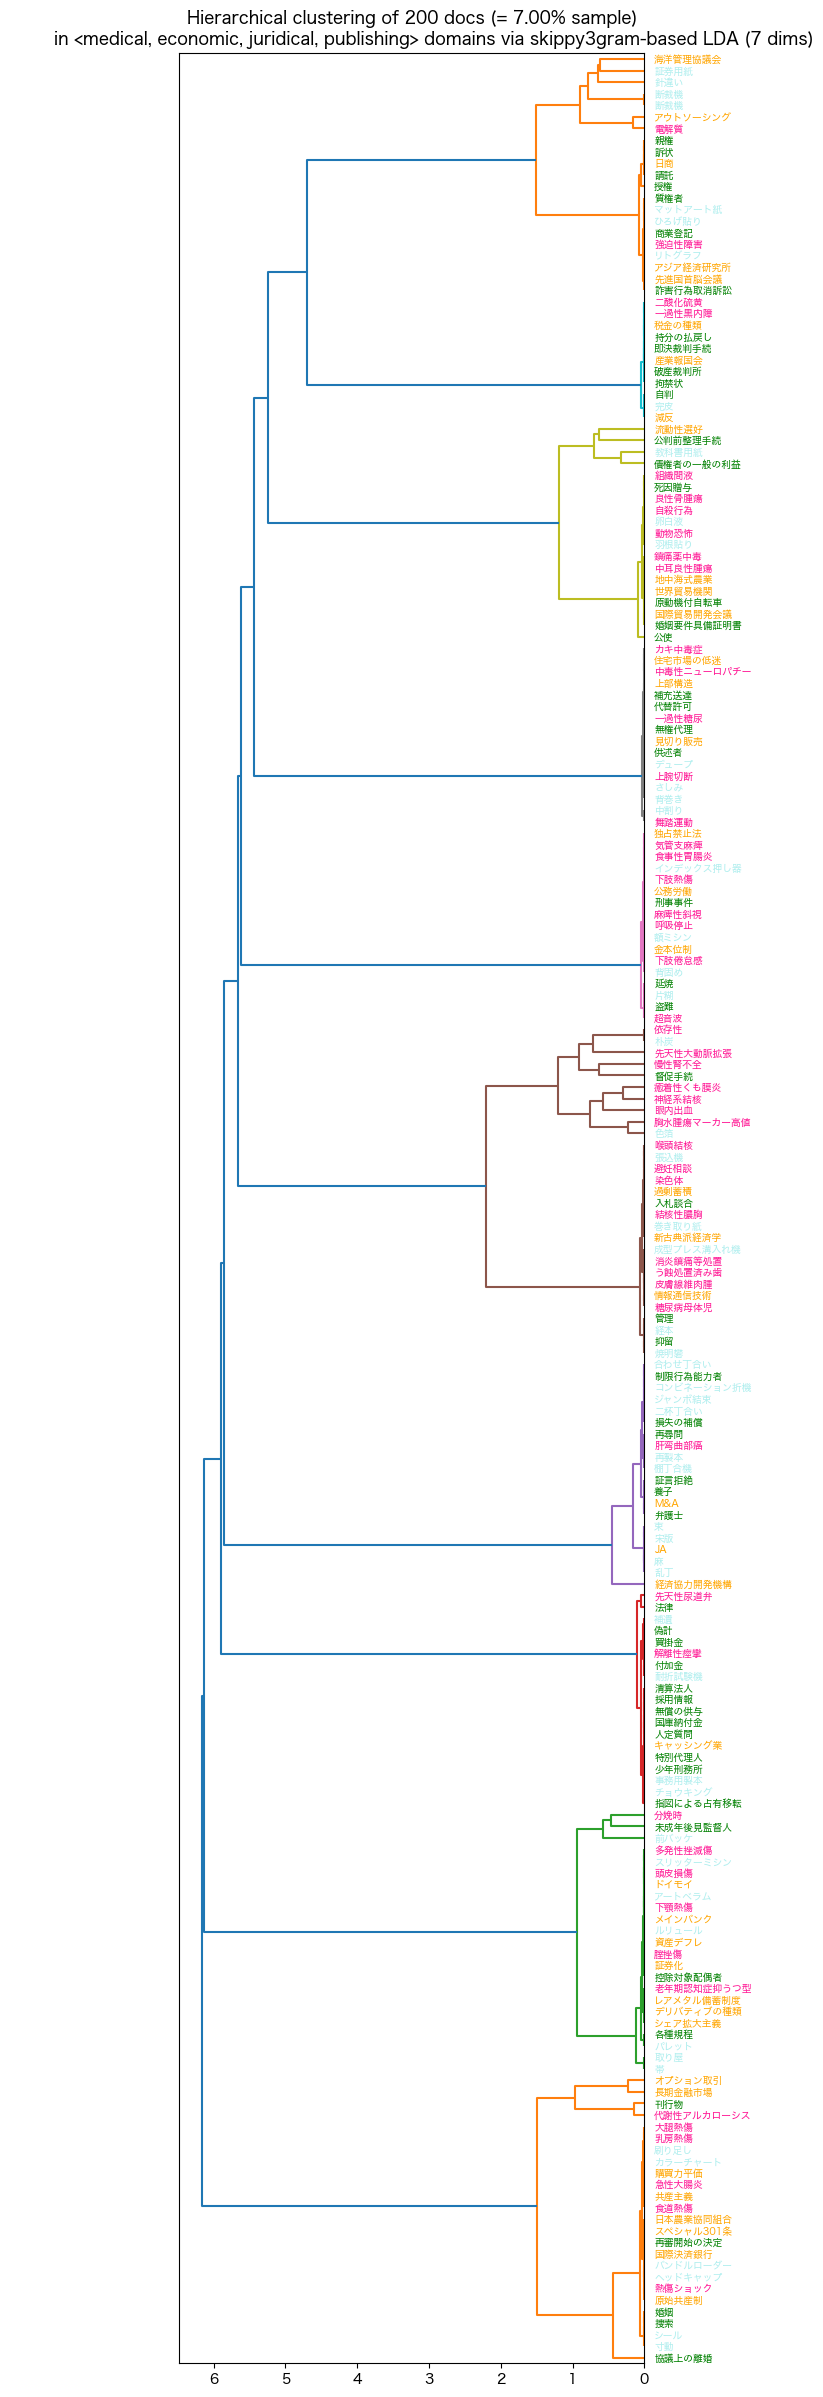

In [ ]:
## doc 階層クラスタリングの実行
import numpy as np
import plotly
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 距離行列の生成
from scipy.cluster.hierarchy import dendrogram, linkage
doc_linkage_plain = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

## 樹状分岐図の作成
dendrogram(doc_linkage_plain, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 題の指定
df_size = len(df_sampled)
sampling_rate = f"{100 * hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
if use_FastText:
    if use_LDA:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via {term_type}-based {encoding_method} (dims: {n_topics}, window size: {window_size})"
    else:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via {encoding_method} (dims: {n_topics}, window size: {window_size})"
else:
    title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
        in <{domain_names}> domains via {term_type}-based {encoding_method} ({n_topics} dims)"
plt.title(title_val)

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    matched_rows = df_sampled.loc[df_sampled[doc_type] == word]
    if len(matched_rows) == 1:
        row = matched_rows
    else:
        row = matched_rows.iloc[0] # matched_rows[0] fails to work
    ## extract domain_id value
    try:
        domain_id = int(row['domain_id'])
        #ticker.set_color(plotly.colors.qualitative.Plotly[domain_id + 1]) # id の基数調整
        ticker.set_color(colormap[domain_id]) # id の基数調整
    except TypeError:
        pass
#
plt.show()